In [3]:
# To display with horizontal scroll
# Enable at presentation time because it makes edition dificult


# from IPython.core.display import HTML
# display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Quantum Machine Learning with PennyLane

#### Sergio Andrés Cotrino Sandoval & José Luis Falla León
#### Friday, March 5th, 2021
#### Chaos & Complexity Group
#### Universidad Nacional de Colombia

## Table of Contents
- Introduction to PennyLane
- PennyLane Features
    - Continuous-variable Architecture
- Example 1: Optimizing a Quantum Optical Neural Network
- Example 2: Variational Quantum Classifier
- Crossover: PennyLane + Qiskit
- References

# Introduction to PennyLane
- Cross-platform, open-source, Python3 library for differentiable programming of quantum computers.
- Facilitates the optimization of both quantum and hybrid quantum-classical algorithms.
- PennyLane can, in principle, be used with any gate-based quantum computing platform as a backend, including both qubit and continuous-variable architectures.
- PennyLane-Qiskit plugin allows for implementation of quantum machine learning algorithms in IBMQ backends.

# Continuous Variables

In the continuos variable (CV) model of quantum computing, the basic information-processing unit  is an infinite-dimensional bosonic mode. Among the advantages for this model:

* Well suited for implementations and applications based on bosons (e.g. electromagnetic fileds, trapped atoms, Bose-Einstein condensates, phonons)
* Well suited for implementations where continuous quantum operators are present - such as position and momentum
* Proven to retain the computational power of the qubit model
* Good flexibility to implementation of deep learning algorithms

A common approach is to model each quantum mode of interest a a quamtum harmonic-oscillator of the electromagnetic field, with attached creation and anihilation operatos and canocally conjugate par of variables.

$$
\begin{aligned}
\hat{x} &:=\sqrt{\frac{\hbar}{2}}\left(\hat{a}+\hat{a}^{\dagger}\right) \\
\hat{p} &:=-i \sqrt{\frac{\hbar}{2}}\left(\hat{a}-\hat{a}^{\dagger}\right)\\
&\left[\hat{x}, \hat{p}\right] =i \hbar
\end{aligned}
$$



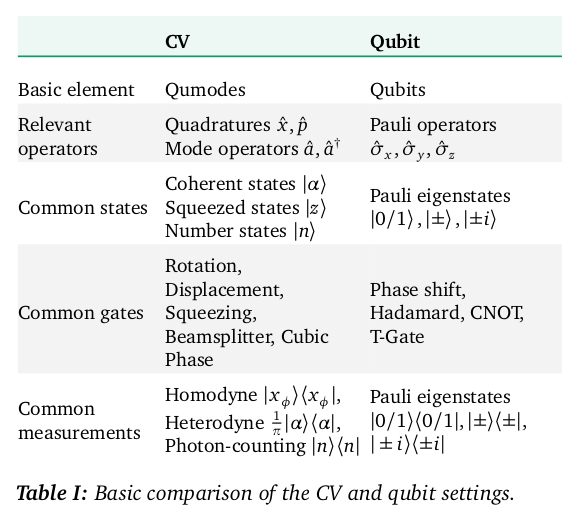
Obtained from Killoran et al.(2019), page 2

# Optimizing a quantum optical neural network

This is a review of the tutorial that can be found on https://pennylane.ai/qml/demos/qonn.html. This Quantum Optica Neural Network (QONN) is based on Fock states, and attempts to apply neural networks and deep learning theory to the quantum case, using quantum data and architecture, and a classical optimization process.

<MORE BACKGROUND>

To create the QONN, layers are used. These consist of a linear interferometer and a non-linear Kerr interaction layer. Both layers are aplied to all modes. More information regarding this layout can be found on Reck et al. (1994). The main idea is that a given sequence of beam splitter transformations can execute any discrete finite-dimensional unitary operation. Image from https://pennylane.ai/qml/demos/qonn.html

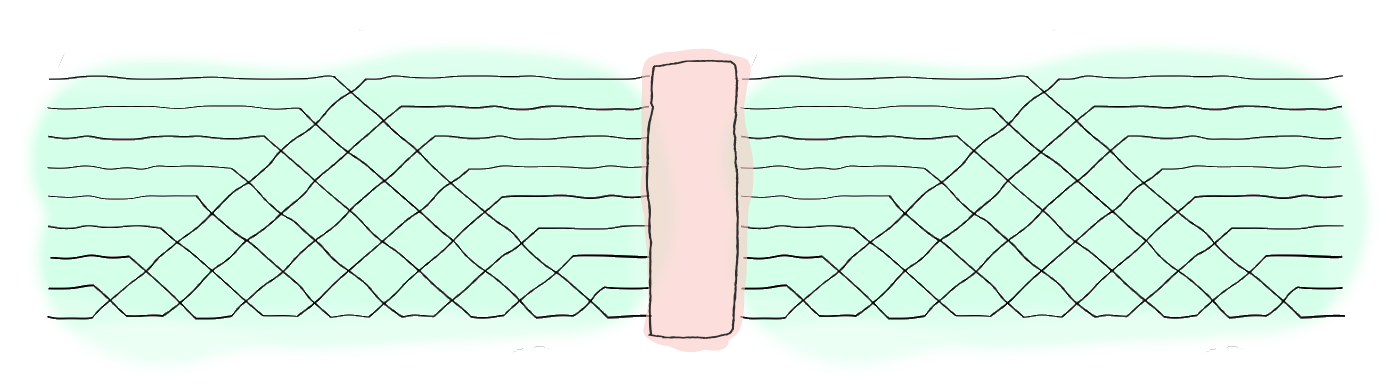


## Circuit Creation

- Create the Strawberry fields simulator. It has as many quantun modes as the quantum-optical neural network is to have. Also, a cutoff param is needed for Fock states.

In [2]:
# Import PennyLane and the numpy wrapper
# Wrapper needed to perform some functions of np in the context of PennyLane
import pennylane as qml
from pennylane import numpy as np

In [3]:
dev = qml.device("strawberryfields.fock", wires=4, cutoff_dim=4)

- Create the layers to be used. 

In [4]:
def layer(theta, phi, wires):
    M = len(wires)
    phi_nonlinear = np.pi / 2

    # Created the interferometer using a template
    qml.templates.Interferometer(
        theta, phi, np.zeros(M), wires=wires, mesh="triangular",
    )

    # Creater the non-linear Kerr interaction layer
    # The parameter for nonlinear interaction is constant
    for i in wires:
        qml.Kerr(phi_nonlinear, wires=i)

- Build the full QONN as a circuit

In [6]:
# The parameters to be optimized are contained in var
# Each element in var is a list of parameters theta and phi for a specific layer.

# The decorator "@qml.qnode(dev)" indicates that the decorated function contains a quantum circuit bounded 
# to a compatible device already created

@qml.qnode(dev)
def quantum_neural_net(var, x):
    wires = list(range(len(x)))

    # Encode input x into a sequence of quantum fock states
    for i in wires:
        qml.FockState(x[i], wires=i)

    # "layer" subcircuits
    for i, v in enumerate(var):
        layer(v[: len(v) // 2], v[len(v) // 2 :], wires)

    # At the end, the number operator is used to obtain the mean photon number in each mode
    return [qml.expval(qml.NumberOperator(w)) for w in wires]

## Cost function

- Define the cost function. It uses the outputs from the QONN (predictions) for each input (data_inputs) and the calculates the square loss between the predictions ans the true outputs (labels).

As a cost function, a helper function is used to aid in the calculation of the normalized square loss of two vectors. If zero, both parameters are equal. If 1, they are fully orthogonal.

In [7]:
# User for several pairs of verctors
def square_loss(labels, predictions):
    term = 0
    for l, p in zip(labels, predictions):
        # Normalization of each vector
        lnorm = l / np.linalg.norm(l)
        pnorm = p / np.linalg.norm(p)

        # The makes the inner product for a pair of vectors
        term = term + np.abs(np.dot(lnorm, pnorm.T)) ** 2

    # Returns the loss: 1 mminus the average of the inner products
    return 1 - term / len(labels)

In [9]:
def cost(var, data_input, labels):
    # Gets the predictions for data_input and then calculates the loss
    predictions = np.array([quantum_neural_net(var, x) for x in data_input])
    sl = square_loss(labels, predictions)

    return sl

## Optimizing the CNOT gate

Now, the network can be optimized by choosing  a function from imput to output states. Four modes were chosen to use a gate of two qubits. In this case, the network is trained as a CNOT gate. Inputs and labels are then defined.

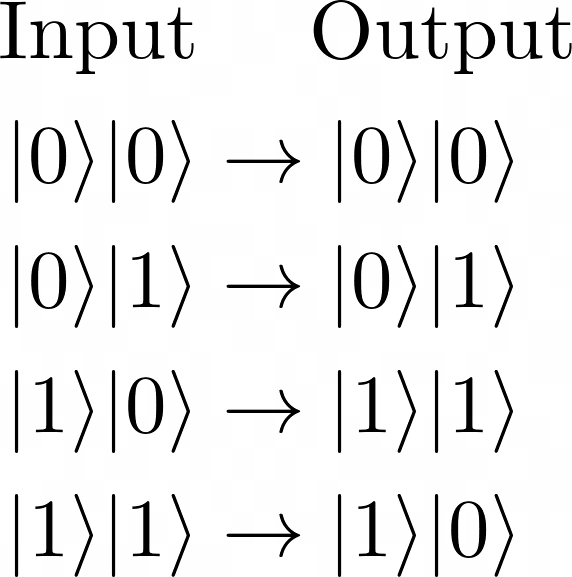

In [10]:
# Define the CNOT input-output states (dual-rail encoding) and initialize
# them as non-differentiable.

X = np.array([[1, 0, 1, 0],
              [1, 0, 0, 1],
              [0, 1, 1, 0],
              [0, 1, 0, 1]], requires_grad=False)

Y = np.array([[1, 0, 1, 0],
              [1, 0, 0, 1],
              [0, 1, 0, 1],
              [0, 1, 1, 0]], requires_grad=False)

Then:

* Define the number of layers
* Calculate and get the corresponding number of initial parameters to use.

In the case bellow, with 4 modes, there are 4*(4-1)=12 variables per layer. This is the pposible number of interactions of the interferometes with a triangular layout.

In [11]:
num_layers = 2
M = len(X[0])
num_variables_per_layer = M * (M - 1)

var_init = (4 * np.random.rand(num_layers, num_variables_per_layer) - 2) * np.pi
print(var_init)

[[ 0.44649261  0.41210471 -4.74250452  5.83428451 -2.80530642  3.36008672
   3.61030206  5.83685284 -2.64962557  1.15000548 -5.93954918  4.05653285]
 [ 5.41041372 -4.47735875  0.43822647  2.19782286 -3.81815685  1.91523848
   0.90973825 -2.1355572  -3.85285685 -5.09985053  5.72977364  2.70602782]]


- Execute a build-in optimizer function from PennyLane for a given number of steeps

In [ ]:
from pennylane.optimize import AdamOptimizer

opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(200):
    var = opt.step(lambda v: cost(v, X, Y), var)

    if (it+1) % 20 == 0:
        print(f"Iter: {it+1:5d} | Cost: {cost(var, X, Y):0.7f} ")

In [12]:
print(f"The optimized parameters (layers, parameters):\n {var}\n")

Y_pred = np.array([quantum_neural_net(var, x) for x in X])
for i, x in enumerate(X):
    print(f"{x} --> {Y_pred[i].round(2)}, should be {Y[i]}")

NameError: name 'var' is not defined

In [13]:
# Finally, we can draw the resulting circuit for a given input
quantum_neural_net(var_init, X[0])
print(quantum_neural_net.draw())

 0: ──|1⟩──────────────────────────────────────╭BS(-4.74, -2.65)───R(0)───────────────Kerr(1.57)──────────────────────────────────────────────────────────────────╭BS(0.438, -3.85)───R(0)──────────────Kerr(1.57)──────────────────────────────┤ ⟨n⟩ 
 1: ──|0⟩────────────────────╭BS(0.412, 5.84)──╰BS(-4.74, -2.65)──╭BS(-2.81, -5.94)───R(0)────────────Kerr(1.57)───────────────────────────────╭BS(-4.48, -2.14)──╰BS(0.438, -3.85)──╭BS(-3.82, 5.73)───R(0)────────────Kerr(1.57)──────────────┤ ⟨n⟩ 
 2: ──|1⟩──╭BS(0.446, 3.61)──╰BS(0.412, 5.84)──╭BS(5.83, 1.15)────╰BS(-2.81, -5.94)──╭BS(3.36, 4.06)──R(0)────────Kerr(1.57)──╭BS(5.41, 0.91)──╰BS(-4.48, -2.14)──╭BS(2.2, -5.1)─────╰BS(-3.82, 5.73)──╭BS(1.92, 2.71)──R(0)────────Kerr(1.57)──┤ ⟨n⟩ 
 3: ──|0⟩──╰BS(0.446, 3.61)────────────────────╰BS(5.83, 1.15)───────────────────────╰BS(3.36, 4.06)──R(0)────────Kerr(1.57)──╰BS(5.41, 0.91)─────────────────────╰BS(2.2, -5.1)───────────────────────╰BS(1.92, 2.71)──R(0)────────Kerr(1.57)──┤ ⟨n⟩ 



# Variational Quantum Classifier
- A circuit can be trained from labelled data to classify new data samples.
- First, show that VQC can reproduce the parity function:
$$ f : x \in \{0, 1\}^{\otimes n} \longrightarrow y = \begin{cases} 1 & \text{if uneven number of ones in x} \\ 0 & \text{otherwise} \end{cases}$$
- This example demonstrates how to encode binary inputs into the initial state of the variational circuit.

In [2]:
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as np
from qiskit import IBMQ
from pennylane.optimize import NesterovMomentumOptimizer

## Fitting the parity function

- First, we create a quantum device (or node) with four wires.

In [3]:
dev = qml.device("default.qubit", wires=4)

- Variational classifiers usually define a "layer" or a "block", which is an elementary circuit that gets repeated to build the variational circuit.
- This circuit layer consists of an arbitrary rotation on every qubit, as well as CNOT gates that entangle each qubit with its neighbor.

In [4]:
def layer(W):
    
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

- To encode data inputs x into the circuit, we use PennyLane's BasisState, which prepares a computational basis state that has 1s where x has 1s:

$$ x = 0101 \longrightarrow \left|\psi\right\rangle = \left|0101\right\rangle$$

- Now we define the quantum node as a state preparation routine, followed by a repetition of the layer structure.

In [5]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

In [6]:
@qml.qnode(dev)
def circuit(weights, x):
    
    state_preparation(x)
    
    for W in weights:
        layer(W)
        
    return qml.expval(qml.PauliZ(0))

In [7]:
def variational_classifier(var, x):
    weights = var[0]
    bias = var[1]
    return circuit(weights, x) + bias

### Cost Function
- In standar supervised learning, a square loss, which measures the distance between target labels and model predictions, is used as a cost function.
- To monitor how many inputs the classifier predicted correctly, we use an accuracy measure given target labels and model predictions.

In [8]:
def square_loss(labels, predictions):
    
    loss = 0
    
    for l, p in zip(labels, predictions):
        loss = loss + (1 - p) ** 2
        
    loss = loss / len(labels)
    
    return loss

In [9]:
def accuracy(labels, predictions):
    
    loss = 0
    
    for l, p in zip(labels, predictions):
        if abs(1 - p) < 1e-5:
            loss = loss + 1
        
    loss = loss / len(labels)
    
    return loss

In [10]:
def cost(var, X, Y):
    
    predictions = [variational_classifier(var, x) for x in X]
    return square_loss(Y, predictions)

In [11]:
data = np.loadtxt("parity.txt")
X = np.array(data[:, :-1], requires_grad=False)
Y = np.array(data[:, -1], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))

for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")

X = [0. 0. 0. 0.], Y = -1
X = [0. 0. 0. 1.], Y =  1
X = [0. 0. 1. 0.], Y =  1
X = [0. 0. 1. 1.], Y = -1
X = [0. 1. 0. 0.], Y =  1
...


In [12]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

print(var_init)

(tensor([[[ 0.01764052,  0.00400157,  0.00978738],
         [ 0.02240893,  0.01867558, -0.00977278],
         [ 0.00950088, -0.00151357, -0.00103219],
         [ 0.00410599,  0.00144044,  0.01454274]],

        [[ 0.00761038,  0.00121675,  0.00443863],
         [ 0.00333674,  0.01494079, -0.00205158],
         [ 0.00313068, -0.00854096, -0.0255299 ],
         [ 0.00653619,  0.00864436, -0.00742165]]], requires_grad=True), 0.0)


In [13]:
circuit(var_init[0], X[0])
print(circuit.draw())

 0: ──╭|0.0⟩──Rot(0.0176, 0.004, 0.00979)──────╭C────────────────────────────────────────────────────────────────────────╭X──Rot(0.00761, 0.00122, 0.00444)───╭C──────────╭X──┤ ⟨Z⟩ 
 1: ──├|0.0⟩──Rot(0.0224, 0.0187, -0.00977)────╰X──╭C───Rot(0.00334, 0.0149, -0.00205)───────────────────────────────────│────────────────────────────────────╰X──╭C──────│───┤     
 2: ──├|0.0⟩──Rot(0.0095, -0.00151, -0.00103)──────╰X──╭C───────────────────────────────Rot(0.00313, -0.00854, -0.0255)──│────────────────────────────────────────╰X──╭C──│───┤     
 3: ──╰|0.0⟩──Rot(0.00411, 0.00144, 0.0145)────────────╰X────────────────────────────────────────────────────────────────╰C──Rot(0.00654, 0.00864, -0.00742)──────────╰X──╰C──┤     



## Optimization

- Variables are initialized randomly (first variable in list is used as bias; the rest are fed into the gates of the variational circuit).
- PennyLane has integrated optimizers: for this particular case, we use the Nesterov Momentum optimizer.
- The accuracy is tracked by computing the outputs of the variational classifier and turning them into predictions in $\{-1,1\}$ by taking the sign of the output.

In [12]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

In [13]:
var = var_init
for it in range(25):
    
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    var = opt.step(lambda v: cost(v, X_batch, Y_batch), var)
    
    predictions = [np.sign(variational_classifier(var, x)) for x in X]
    acc = accuracy(Y, predictions)
    
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(var, X, Y), acc
        )
    )

Iter:     1 | Cost: 1.9985253 | Accuracy: 0.5000000 
Iter:     2 | Cost: 1.0364115 | Accuracy: 1.0000000 
Iter:     3 | Cost: 1.3452707 | Accuracy: 1.0000000 
Iter:     4 | Cost: 1.9515917 | Accuracy: 1.0000000 
Iter:     5 | Cost: 0.8491429 | Accuracy: 0.5000000 
Iter:     6 | Cost: 0.7826443 | Accuracy: 0.5000000 
Iter:     7 | Cost: 0.4137376 | Accuracy: 0.8750000 
Iter:     8 | Cost: 0.0751646 | Accuracy: 1.0000000 
Iter:     9 | Cost: 0.0422179 | Accuracy: 1.0000000 
Iter:    10 | Cost: 0.0270981 | Accuracy: 1.0000000 
Iter:    11 | Cost: 0.0115996 | Accuracy: 1.0000000 
Iter:    12 | Cost: 0.0033051 | Accuracy: 1.0000000 
Iter:    13 | Cost: 0.0002077 | Accuracy: 1.0000000 
Iter:    14 | Cost: 0.0012965 | Accuracy: 1.0000000 
Iter:    15 | Cost: 0.0041511 | Accuracy: 1.0000000 
Iter:    16 | Cost: 0.0012049 | Accuracy: 1.0000000 
Iter:    17 | Cost: 0.0003573 | Accuracy: 1.0000000 
Iter:    18 | Cost: 0.0004377 | Accuracy: 1.0000000 
Iter:    19 | Cost: 0.0002229 | Accuracy: 1.00

## Iris Classification
- For this classification problem, we need to encode real-valued vectors into the amplitudes of a quantum state.
- State preparation is not as simple as representing a bitstring with a basis state: every input x has to be translated into a set of angles which can get fed into a small routine for state preparation.

In [14]:
dev2 = qml.device("default.qubit", wires=2)

In [15]:
def get_angles(x):
    
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2))
    
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def state_preparation2(a):
    qml.RY(a[0], wires=0)
    
    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)
    
    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)
    

In [16]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)

@qml.qnode(dev2)
def test(angles):
    
    state_preparation2(angles)
    
    return qml.expval(qml.PauliZ(0))

test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev2.state))

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [ 0.56397465 -0.          0.         -0.97504604  0.97504604]
amplitude vector:  [ 5.38967743e-01  7.95036065e-01  2.78265032e-01 -2.77555756e-17]


In [17]:
def layer2(W):
    
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [18]:
@qml.qnode(dev2)
def circuit2(weights, angles):
    state_preparation2(angles)
    
    for W in weights:
        layer2(W)
    
    return qml.expval(qml.PauliZ(0))

def variational_classifier2(var, angles):
    weights = var[0]
    bias = var[1]
    return circuit2(weights, angles) + bias

def cost2(weights, features, labels):
    predictions = [variational_classifier2(weights, f) for f in features]
    return square_loss(labels, predictions)

In [19]:
data = np.loadtxt("iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print('First X sample (original)     : ', X[0])

padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)       : ", X_pad[0])

normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized)   : ", X_norm[0])

features = np.array([get_angles(x) for x in X_norm])
print("First features sample         : ", features[0])

Y = data[:, -1]

First X sample (original)     :  [0.4  0.75]
First X sample (padded)       :  [0.4  0.75 0.3  0.  ]
First X sample (normalized)   :  [0.44376016 0.83205029 0.33282012 0.        ]
First features sample         :  [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


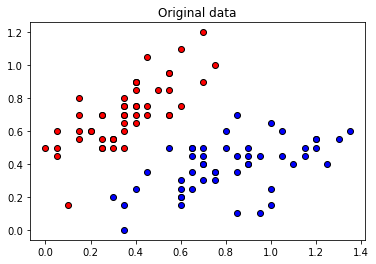

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

In [21]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [22]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

In [23]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
var = var_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost2(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier2(var, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier2(var, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost2(var, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 0.1009213 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     2 | Cost: 0.0925796 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     3 | Cost: 0.0801384 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     4 | Cost: 0.0672340 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     5 | Cost: 0.0559089 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     6 | Cost: 0.0464627 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     7 | Cost: 0.0365217 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     8 | Cost: 0.0299786 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:     9 | Cost: 0.0257101 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:    10 | Cost: 0.0232234 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:    11 | Cost: 0.0217870 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:    12 | Cost: 0.0209337 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    13 | Co

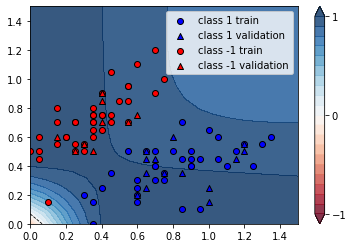

In [24]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier2(var, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

# PennyLane + Qiskit Integration
- The PennyLane-Qiskit module plugin integrates Qiskit's quantum computing framework with PannyLane's quantum machine learning capabilities.
- Requirements: IBMid + API token
- Now, we only need to redefine our device with one of IBMQ's backends (quantum devices or classical simulators).

In [61]:
IBMQ.load_account()
IBMQ.providers()

/Users/jfalla/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science')>]

In [64]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [91]:
devq = qml.device('qiskit.ibmq', wires=4, backend='ibmq_qasm_simulator', provider=provider, shots=1000)

# References

- [PennyLane](https://pennylane.ai/)
- [PennyLane: Automatic differentiation of hybrid quantum-classical computations](https://arxiv.org/abs/1811.04968)
- [An Overview of Gradient Descent Optimization Algorithms](https://ruder.io/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms)
- [Reck, Michael, et al. "Experimental realization of any discrete unitary operator." Physical review letters 73.1 (1994): 58.
](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.73.58)
- [Killoran, Nathan, et al. "Strawberry fields: A software platform for photonic quantum computing." Quantum 3 (2019): 129.
](https://quantum-journal.org/papers/q-2019-03-11-129/)